本文展示了如何多贝叶斯层次模型来解决盖革计数器问题。

盖革计数器
>盖革计数器（Geiger counter）又叫盖革-米勒计数器（Geiger-Müller counter），是一种用于探测电离辐射的粒子探测器，通常用于探测α粒子和β粒子，也有些型号盖革计数器可以探测γ射线及X射线。

# 1. 盖革计数器问题

有一个放射源，以平均每秒$\lambda$个粒子的速度放射粒子，用一个盖格计数器来记录放射的粒子数。由于放射源放射的粒子会以固定的速率衰变，因此记数器只能记录到一部分粒子（占比$r=10\%$）。如果记数器每秒记录的离子数$k=15$，那么放射源每秒发射粒子数$n$的后验分布是什么？放射源发射粒子速率$\lambda$的分布是什么？

**问题分析**
+ 放射源以每秒$\lambda$的速率发射粒子，由概率知识可知，发射粒子数$n$服从参数为$\lambda$的**泊松分布**，即$$N\sim P(\lambda)$$  
+ 记数器以$r$的比率记录放射出的粒子，记录数$k$服从参数为$(n、r)$的**二项分布**，即$$K\sim B(n,r)$$


**背景知识**

> **泊松分布**（Poisson distribution）适用于描述单位时间内随机事件发生的次数的概率分布。如某一服务设施在一定时间内受到的服务请求的次数，电话交换机接到呼叫的次数、汽车站台的候客人数、机器出现的故障数、自然灾害发生的次数、DNA序列的变异数、放射性原子核的衰变数、激光的光子数分布等等。若$X$服从参数为$\lambda$的泊松分布，记为$X\sim P(\lambda)$。泊松分布的概率质量函数为：$$P(X=k)=\frac{e^{-\lambda}\lambda^{k}}{k!} \tag{1}$$泊松分布的参数$λ$是单位时间（或单位面积）内随机事件的平均发生率。  
> <center><img src="./statics/11/800px-Poisson_pmf.svg.png" width="480" alt="二项分布" align=center></center>
> <center>横轴是发生次数$k$。该函数是离散函数，$k$的定义域为整数，连接线是只为了视觉效果。</center><center><font size=4>概率质量函数</font></center>

> **二项分布**（Binomial distribution）是n个独立的是/非试验中成功的次数的离散概率分布，其中每次试验的成功概率为$p$。这样的单次成功/失败试验又称为伯努利试验。实际上，当$n=1$时，二项分布就是伯努利分布。二项分布是显著性差异的二项试验的基础。一般地，如果随机变量$X$服从参数为$n$和$p$的二项分布，我们记$X\sim B(n,p)$。n次试验中正好得到k次成功的概率二项分布概率质量函为：$$P(X=k)=
\left( 
  \begin{matrix}
   n \\
   k \\
  \end{matrix}
\right)p^{k}(1-p)^{n-k} \tag{2}
$$其中，$k=0,1,2,3,…,n$。  
> <center><img src="./statics/11/1024px-Binomial_distribution_pmf.svg.png" width="480" alt="二项分布" align=center></center>
> <center><font size=4>概率质量函数</font></center>

# 2 对$N$建模的简单贝叶斯方法

已知放射源放出的粒子数为$n$，其中占比为$r$的粒子被成功记录，记录值为$k$，$K\sim B\left( n,r \right)$。用贝叶斯方法求解，就是在已知记录数为$k$的条件下，求参数$n$的分布。根据贝叶斯公式，我们有：
$${p}_{N|K}(n|k)=\frac{{p}_{N}(n)\centerdot {p}_{K|N}(k|n)}{\sum_{n'}{p}_{N}(n')\centerdot {p}_{K|N}(k|n')}$$  
其中：  
+ ${p}_{N|K}(n|k)$为$n$的**后验分布**。
+ ${p}_{N}(n)$为$n$的**先验分布**。在本例中，$n$的先验分布为泊松分布$P(\lambda)$，$\lambda$为放射源发射粒子的速率。
+ ${p}_{N|K}(k|n)$为**似然函数**。在本例中，已知$n$的条件下，$k$的似然函数为二项分布函数$B(n,p)$。
+ $P(K)=\sum_{n'}p_{N}(n')p_{K|N}(k|n')$为**归一化常数**，其值仅取决于观测值$k$。

<center><img src="./statics/11/n的概率模型.png" width="480" alt="二项分布" align=center></center>

运用Python对该模型进行编程，主要分为以下4个步骤：
+ 第一步：编写$n$的先验分布——泊松分布$P(\lambda)$。
+ 第二步：编定似然函数——二项分布$B(n,p)$。
+ 第三步：计算先验分布与似然函数的乘积。
+ 第四步：对第三步计算结果归一化处理。不需要计算归一化函数。

## 2.1 $n$的先验分布——泊松分布

In [1]:
from tools import Pmf

tools模块中的**Suite类**提供贝叶斯方法的基本操作。Suite对象具有属性d。
d是类型为“键-值”对组成的字典。字典的键,代表随机变量取值;字典的值,为对应随机变量的概率值。

In [2]:
def MakePoissonPmf(lam, high, step=1):
    """生成泊松分布的近似概率质量函数。

    lam: 参数lambda，单位时间内事件发生的数量
    high: 随机变量取值的上限

    返回: 标准化的概率质量函数
    """
    pmf = Pmf()
    for n in range(0, high + 1, step):
        # 当泊松分布的参数lambda的值为lam时，计算事件出现k次的概率
        p = EvalPoissonPmf(n, lam)
        pmf.Set(n, p)
    pmf.Normalize()
    return pmf

In [3]:
from scipy.stats import poisson
def EvalPoissonPmf(n, lam):
    """计算泊松分布的概率质量。

    n: 事件的数量
    lam: 参数lambda，单位时间内事件发生的数量

    返回: 概率值，浮点数
    """
    x = poisson.pmf(n, lam)
    return x if x else 0

当lam=150, high=150时, 函数MakePoissonPmf生成的概率质量函数的图形为。

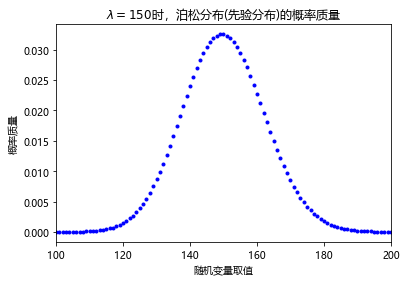

In [4]:
from matplotlib import pyplot as plt
# 生成lambda为150的泊松分布
possion_pmf = MakePoissonPmf(150, 500)

# 随机变量的取值列表和概率列表，作图用
x,y = zip(*possion_pmf.Items())
# 作图
plt.plot(x,y,".b")
plt.xlim(100,200)
plt.title('$\lambda=150$时，泊松分布(先验分布)的概率质量')
plt.xlabel('随机变量取值')
plt.ylabel('概率质量')
plt.show()

## 2.2 似然函数——二项分布

In [5]:
import scipy
def EvalBinomialPmf(k, n, p):
    """Evaluates the binomial pmf.

    Returns the probabily of k successes in n trials with probability p.
    """
    return scipy.stats.binom.pmf(k, n, p)

## 2.3 计数器模型——Detector类

有了MakePoissonPmf和EvalBinomialPmf，就可以编写盖格计数器的Detector类。该类提供以下功能：
+ 在实例初始化时利用MakePoissonPmf生成先验分布（第一步）；
+ Likelihood方法调用EvalBinomialPmf函数生成似然函数（第二步）；
+ 从父类Suite继承了Update方法，用于计算先验分布与似然函数的乘积（第三步）；
+ 从父类Suite继承了Normalize方法，用于对概率质量函数进行归一化处理（第四步）。

In [6]:
from tools import Suite
import matplotlib.pyplot as plt
class Detector(Suite):
    """放射源发射离子数量n的分布的模型。"""

    def __init__(self, lam, r, high=500, step=5):
        """初始化Suite对象。

        lam: 已知离子发射速率, lambda
        r: 记录的离子数的比例, r
        high: 离子的最大数量, n
        step: n的假设值之间的步长
        """
        # 根据放射源的速率，生成泊松分布的概率密度对象
        # 对N的每一个取值，生成其对应的概率值，
        pmf = MakePoissonPmf(lam, high, step=step)
        Suite.__init__(self, pmf, name=lam)
        self.lam = lam
        self.r = r

    def Likelihood(self, data, hypo):
        """给定假设的似然函数。
        即：计数器检测到粒子数为data，当n取不同值时，
        得到data这个结果的概率。

        data: 记录到的粒子数
        hypo: 击中记数器的料子数, n
        """
        k = data
        n = hypo
        p = self.r

        return EvalBinomialPmf(k, n, p)

    def SuiteLikelihood(self, data):
        """将更新数据后的后验分布概率值相加。用于下一步计算lambda的后验概率

        data: 检测到的粒子数。
        """
        total = 0
        for hypo, prob in self.Items():
            like = self.Likelihood(data, hypo)
            total += prob * like
        return total
    
    

Suite类的Update方法定义如下，用于计算先验分布与似然函数的乘积。

Suite类的Normalize方法定义如下。

## 2.4 计算$n$的后验分布

下面显示当$r$=0.1，$k$=15，$\lambda$的取值分别为100、250、400时，$n$的后验分布。

In [7]:
import matplotlib.pyplot as plt
def pmf_plot(ax,pmf):
    """作出pmf对象的概率质量函数图"""
    x,y = zip(*sorted([x for x in pmf.Items()]))
    ax.plot(x,y,label=pmf.name)
    return ax

当lam的值为100时，n的最大似然值为104
当lam的值为250时，n的最大似然值为239
当lam的值为400时，n的最大似然值为375


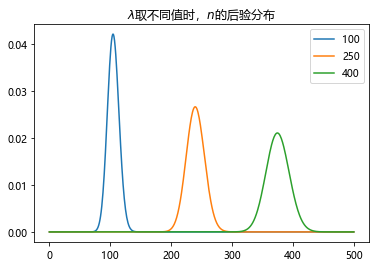

In [8]:
r = 0.1
k = 15

pig = plt.Figure()
ax = plt.subplot()
    
for lam in [100,250,400]:
    suite = Detector(lam, r, step=1)
    suite.Update(k)
    pmf_plot(ax,suite)
    print(f"当lam的值为{lam}时，n的最大似然值为{suite.MaximumLikelihood()}")
    
plt.legend()
plt.title('$\lambda$取不同值时，$n$的后验分布')
plt.show()

# 3 对$\Lambda$建模的分层贝叶斯方法

再回到盖格计数器的第2个问题：求放射源每秒发射离子数$\lambda$的分布，即$P(\Lambda \mid K)$。在$\Lambda$与$K$之间，我们需要引入中间变量$N$串起一个完整的因果链。
<center><img src="./statics/11/反向模型 2019-09-22 195511.png" width="480" alt="二项分布" align=center></center>

此时，我们可以得到如下贝叶斯公式：$$P(\lambda \mid k) = {P(\lambda) \centerdot P(k \mid \lambda) \over \sum_{\lambda \in \Lambda} P(\lambda) \centerdot P(k \mid \lambda)}$$
其中， $P(k \mid \lambda)$为似然概率函数，在引入中间变量$n$后，我们有
$$\begin{align}
P(k \mid \lambda) & = P(k ,{n}_{1} \mid \lambda) + P(k ,{n}_{2} \mid \lambda) + P(k ,{n}_{3} \mid \lambda) + \dots \\
                 & =  P(k \mid {n}_{1}, \lambda)P({n}_{1} \mid \lambda) +  P(k \mid {n}_{2}, \lambda)P({n}_{2} \mid \lambda) +   P(k \mid {n}_{3}, \lambda)P({n}_{3} \mid \lambda) + \dots \\
                 & = \sum_i P(k \mid {n}_{i}, \lambda) \centerdot P({n}_{i} \mid \lambda)
\end{align} \tag 3$$

其中
+ 右边第一项P(k \mid {n}_{i}, \lambda)，表示发射了${n}_{i}$个粒子，被成功检测到的粒子数$k$的分布函数，这是一个二项分布。即
$$K \sim B({n}_{i}, p) \tag 4$$
+ 右边第二项P({n}_{i} \mid \lambda)，表示放射源平均每秒放射$\lambda$个粒子，每秒放射的粒子总数$n$的分布，这是一个泊松分布，即
$$n \sim P(\lambda) \tag 5$$
在Detector类中，已经根据上式编写了似然函数$(3)$。

In [9]:
def SuiteLikelihood(self, data):
    """将更新数据后的后验分布概率值相加。用于下一步计算lambda的后验概率

    data: 检测到的粒子数。
    """
    total = 0
    # 遍历每一个n的取值利用公式（3）计算似然值
    for hypo, prob in self.Items():
        like = self.Likelihood(data, hypo) # 公式（4）
        # prob来自先验，Detector类在初始化时调用2.1节的
        # 函数MakePoissonPmf计算公式（5）
        total += prob * like
    return total

类似第2节做法，我们可以编写如下Emitter类。

In [10]:
from tools import MakePmfFromItems,MakeMixture
class Emitter(Suite):
    """粒子放射源参数lambda的概率模型."""

    def __init__(self, rs, r=0.1):
        """初始化先验概率.

        rs: 粒子发射速率lambda可能的取值。
        r: 记数器记录到的粒子数的比例。
        """
        # 先验分布是lambda生成的一个对象，可以看作是lambda的一个函数。
        detectors = [Detector(lam, r) for lam in rs]
        # 假设先验是均匀分布。
        Suite.__init__(self, detectors)

    def Update(self, data):
        """根据数据更新概率质量。

        data: 检测到的粒子数。
        """
        # 更新每一个detector的概率值
        Suite.Update(self, data)
        
        for detector in self.Values():
            detector.Update(data)

    def Likelihood(self, data, hypo):
        """给定假设，计算似然值

        Args:
            data: 检测到的粒子数
            hypo: 每秒放射的粒子数, lambda

        Returns:
            指定假设情况下的概率质量函数。
        """
        detector = hypo
        like = detector.SuiteLikelihood(data)
        return like

    def DistOfR(self, name=''):
        """计算lambda的分布。"""
        items = [(detector.lam, prob) for detector, prob in self.Items()]
        return MakePmfFromItems(items, name=name)

    def DistOfN(self, name=''):
        """计算n的分布。"""        
        return MakeMixture(self, name=name)

当$lambda$的取值范围为[1,500]时，生成Emitter的一个实例。

In [11]:
hypos = range(1, 501, 5)
emitter = Emitter(hypos, r=0.1)

在一秒钟内，计数器检测到了15个粒子，对后验分布进行更新。

In [12]:
emitter.Update(15)

计算$n$和$\lambda$的后验分布。在Emitter类中的概率变量是Detecor的实例，可以将Detecor的实例看作是随机变量$n$和$\lambda$的函数。

In [13]:
post_lambda = emitter.DistOfR(name='$\lambda$的后验分布')
post_n = emitter.DistOfN(name='n的后验分布')

******


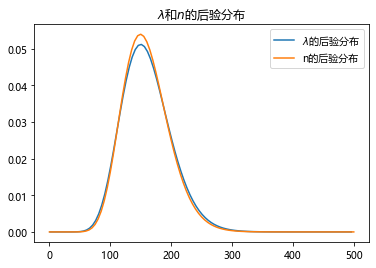

In [14]:
from matplotlib import pyplot as plt

# 随机变量的取值列表和概率列表，作图用
x,y = zip(*post_lambda.Items())
x2,y2 = zip(*post_n.Items())
# 作图
plt.plot(x,y,'-',x2,y2,'-')
plt.legend(['$\lambda$的后验分布','n的后验分布'], loc='best')
plt.title('$\lambda$和$n$的后验分布')
plt.show()

本文例子来自Allen B. Downey的《Think Bayes》一书，内容作了增补和修改。本文贝叶斯分层模型的例子较为复杂，一个更简单的例子可参考[贝叶斯分层模型之一：疾病筛查](https://nbviewer.jupyter.org/github/HuRongxing/thinkbayes/blob/master/%E8%B4%9D%E5%8F%B6%E6%96%AF%E5%88%86%E5%B1%82%E6%A8%A1%E5%9E%8B%EF%BC%9A%E4%B8%80%E4%B8%AA%E7%96%BE%E7%97%85%E7%AD%9B%E6%9F%A5%E7%9A%84%E4%BE%8B%E5%AD%90.ipynb)。